In [3]:
library(dplyr)
library(readr)
# library(urbnmapr)
library(stringr)
library(lubridate)
library(ggplot2)
library(tidyr)
library(lfe)


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date

Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand



In [4]:
naics_weekly = read_csv("/nfs/sloanlab004/projects/covid_mobility_proj/data/PROCESSED_DATA/safegraph_weekly_patterns_2_digit_naics_aggregate_county.csv") %>% 
  mutate(two_digit_naics = as.character(two_digit_naics)) %>% 
  mutate(visitor_vs_visit = raw_visitor_count / raw_visit_count)
head(naics_weekly)


map_naics = read_csv("/nfs/sloanlab004/projects/covid_mobility_proj/data/naics_codes/2017_naics_codes.csv")
colnames(map_naics)[1:3] = c("seq_no", "naics_code", "naics_title")
map_naics= map_naics %>% mutate(naics_code = as.character(naics_code)) %>% filter(!is.na(seq_no)) %>%
  add_row(naics_code = c(31, 32, 33, 44, 45, 48, 49), naics_title = c(rep("Manufacturing", 3), "Retail Trade", "Retail Trade",
                                                                      "Transportation and Warehousing", "Transportation and Warehousing"),
          seq_no = c(nrow(map_naics): (nrow(map_naics)+6)))

jhu_data = read_csv("/nfs/sloanlab004/projects/covid_mobility_proj/data/jhu_data/national/public_implementations_fips.csv")
colnames(jhu_data)[2:3] = c("County", "State")

joined_data <- naics_weekly %>% left_join(map_naics %>% select(naics_code, naics_title), by=c('two_digit_naics' = 'naics_code')) %>% 
  left_join(jhu_data, by = c('county_fips'='FIPS')) %>% filter(!is.na(County)) %>% filter(!is.na(naics_title)) 
joined_data%>%
  group_by(naics_title, ds) %>%
  summarize(sum_visit = sum(raw_visit_count), sum_visitor = sum(raw_visitor_count)) -> agg_data
  
agg_data = agg_data %>% mutate(visit_ratio = sum_visitor/sum_visit)
agg_data1 = agg_data%>% filter(naics_title %in% unique(agg_data$naics_title)[1:10])
agg_data2 = agg_data%>% filter(naics_title %in% unique(agg_data$naics_title)[11:length(unique(agg_data$naics_title))])


naics_daily = read_csv('/nfs/sloanlab004/projects/covid_mobility_proj/data/PROCESSED_DATA/safegraph_daily_patterns_2_digit_naics_aggregate_county.csv') %>% 
  mutate(two_digit_naics = as.character(two_digit_naics))

df = naics_daily %>% left_join(map_naics %>% select(naics_code, naics_title), by=c('two_digit_naics' = 'naics_code')) %>% 
  left_join(jhu_data, by = c('county_fips'='FIPS')) %>% filter(!is.na(County)) %>% filter(!is.na(naics_title)) 

df = df %>% group_by(date, naics_title) %>% summarise(total_visit = sum(raw_visit_count, na.rm = TRUE)) %>% 
  mutate(log_visit = log(total_visit+1)) %>% 
  filter(naics_title %in% c("Accommodation and Food Services", "Arts, Entertainment, and Recreation",
           "Agriculture, Forestry, Fishing and Hunting", "Construction", "Educational Services", 
           "Manufacturing", "Mining, Quarrying, and Oil and Gas Extraction", "Retail Trade"))



Parsed with column specification:
cols(
  ds = col_date(format = ""),
  county_fips = col_integer(),
  two_digit_naics = col_integer(),
  raw_visit_count = col_integer(),
  raw_visitor_count = col_integer()
)


ds,county_fips,two_digit_naics,raw_visit_count,raw_visitor_count,visitor_vs_visit
2020-02-29,66010,44,169575,113455,0.6690550
2020-02-29,66010,45,46420,33530,0.7223180
2020-02-29,66010,48,2560,1280,0.5000000
2020-02-29,66010,51,2800,2180,0.7785714
2020-02-29,66010,52,10,10,1.0000000
2020-02-29,66010,53,14980,8260,0.5514019


Warning message:
“Missing column names filled in: 'X4' [4], 'X5' [5], 'X6' [6]”Parsed with column specification:
cols(
  `Seq. No.` = col_integer(),
  `2017 NAICS US   Code` = col_character(),
  `2017 NAICS US Title` = col_character(),
  X4 = col_character(),
  X5 = col_character(),
  X6 = col_character()
)
Warning message:
“Missing column names filled in: 'X2' [2], 'X3' [3]”Parsed with column specification:
cols(
  FIPS = col_integer(),
  X2 = col_character(),
  X3 = col_character(),
  `stay at home` = col_character(),
  `>50 gatherings` = col_character(),
  `>500 gatherings` = col_character(),
  `public schools` = col_character(),
  `restaurant dine-in` = col_character(),
  `entertainment/gym` = col_character(),
  `Federal guidelines` = col_character(),
  `foreign travel ban` = col_character()
)
Parsed with column specification:
cols(
  date = col_date(format = ""),
  county_fips = col_integer(),
  two_digit_naics = col_integer(),
  raw_visit_count = col_integer()
)


In [ ]:
ggplot(agg_data1, aes(x = ds, y = visit_ratio)) +
  geom_line(aes(color = naics_title, linetype = naics_title) ) + ylim(0,1) + 
  labs(x='Dates', y='Unique visitors / Total visits', title = 'Percentage of Unique Visits Each week')
ggsave("weekly_visit_ratio1.png", height = 6, width = 10)

ggplot(agg_data2, aes(x = ds, y = visit_ratio)) +
  geom_line(aes(color = naics_title, linetype = naics_title) ) + ylim(0,1)+ 
  labs(x='Dates', y='Unique visitors / Total visits', title = 'Percentage of Unique Visits Each week')
ggsave("weekly_visit_ratio2.png", height = 6, width = 10)
  
  # geom_col(aes(x = ds, y = visit_ratio, fill = naics_title)) + 
  # facet_wrap(~naics_title, scales = "free_y")
# ggsave("weekly_visit_ratio.png", height = 10, width = 20)


ggplot(agg_data1, aes(x = ds, y = visit_ratio * log(sum_visitor))) +
  geom_line(aes(color = naics_title, linetype = naics_title) ) + 
  labs(x='Dates', y='Unique visitors/Total visits x log(Unique visitors)', title = 'Weekly Weighted Ratio of Unique Visits')
ggsave("weekly_visit_weighted_ratio1.png", height = 6, width = 10)

ggplot(agg_data2, aes(x = ds, y = visit_ratio* log(sum_visitor))) +
  geom_line(aes(color = naics_title, linetype = naics_title) ) +
  labs(x='Dates', y='Unique visitors / Total visits x log(Unique visitors)', title = 'Weekly Weighted Ratio of Unique Visits')
ggsave("weekly_visit_weighted_ratio2.png", height = 6, width = 10)

ggplot(agg_data1, aes(x = ds, y = visit_ratio * log(sum_visit))) +
  geom_line(aes(color = naics_title, linetype = naics_title) ) + 
  labs(x='Dates', y='Unique visitors/Total visits x log(Unique visitors)', title = 'Weekly Weighted Ratio of Unique Visits')
ggsave("weekly_visit_weighted_ratio3.png", height = 6, width = 10)

ggplot(agg_data2, aes(x = ds, y = visit_ratio* log(sum_visit))) +
  geom_line(aes(color = naics_title, linetype = naics_title) ) +
  labs(x='Dates', y='Unique visitors / Total visits x log(Unique visitors)', title = 'Weekly Weighted Ratio of Unique Visits')
ggsave("weekly_visit_weighted_ratio4.png", height = 6, width = 10)


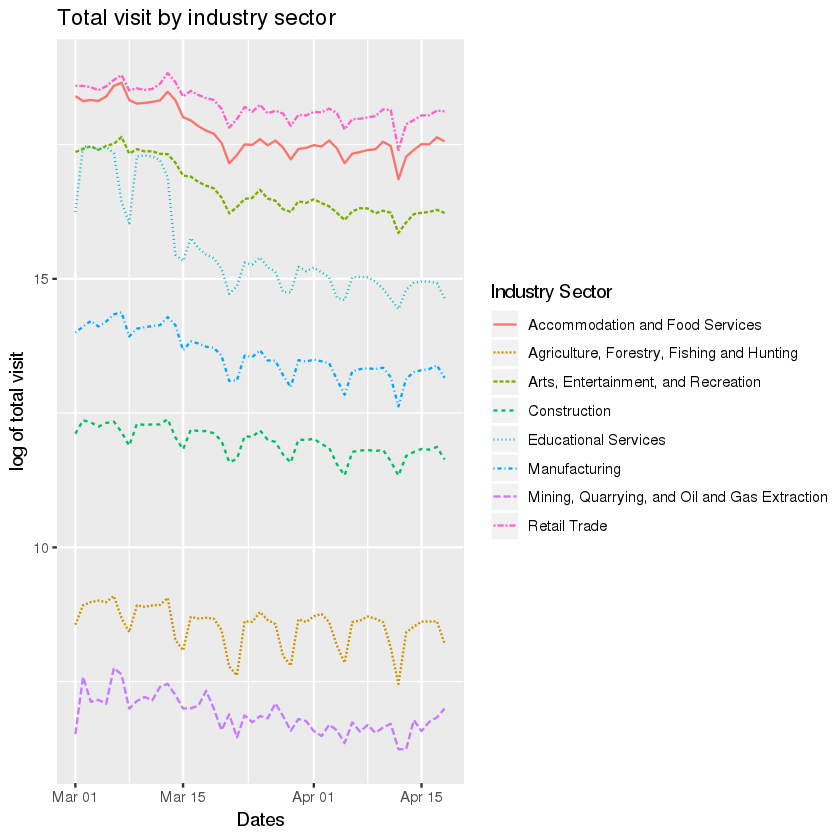

In [10]:
df %>% rename(`Industry Sector` = 'naics_title') %>% 
  ggplot(aes(x = date, y = log_visit)) +
  geom_line(aes(color = `Industry Sector`, linetype = `Industry Sector`) ) + 
  labs(x='Dates', y='log of total visit', title = 'Total visit by industry sector')
ggsave("/home/yiqunc/covid_mobility/paper_code/output/figures/log_visit_by_industry.pdf", height = 6, width = 10)
ggsave("/home/yiqunc/covid_mobility/paper_code/output/figures/log_visit_by_industry.png", height = 6, width = 10)